In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

In [6]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [7]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


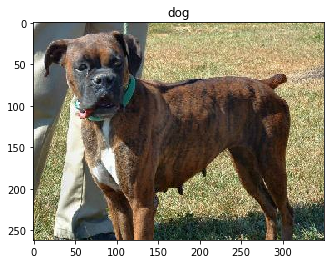

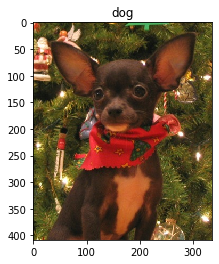

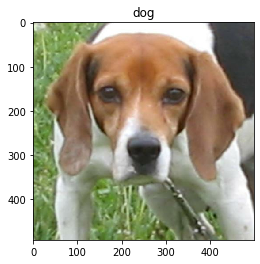

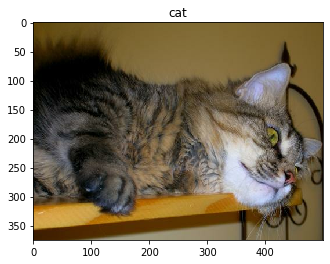

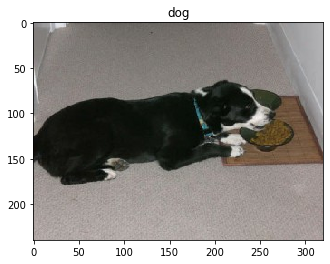

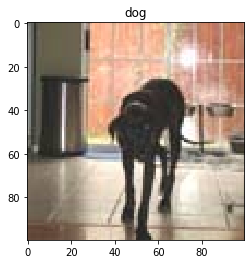

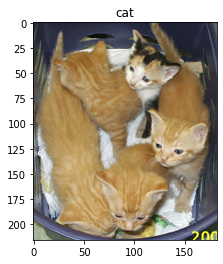

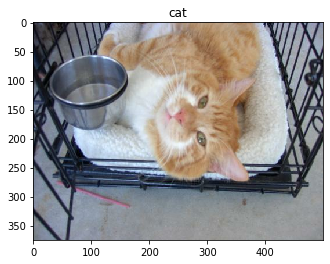

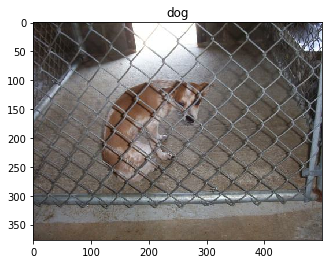

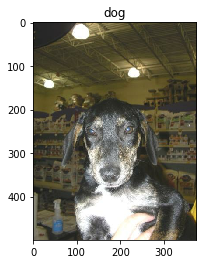

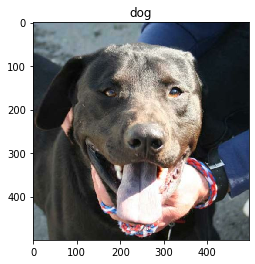

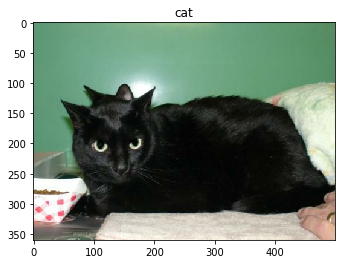

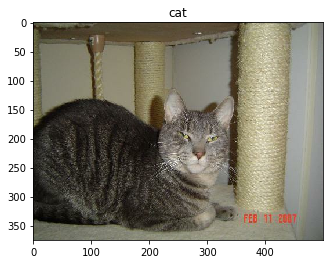

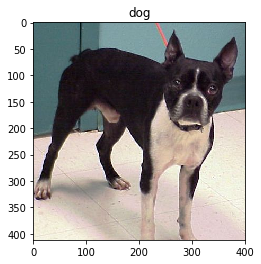

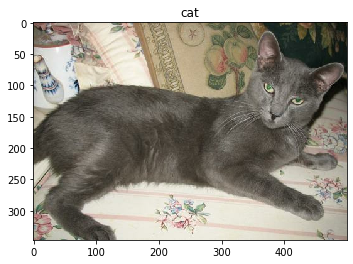

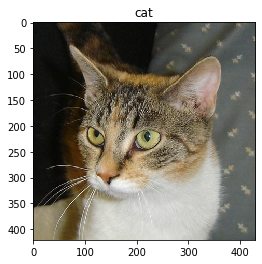

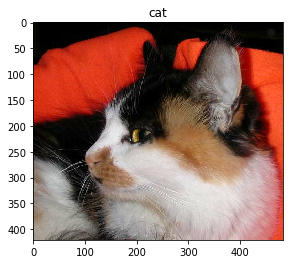

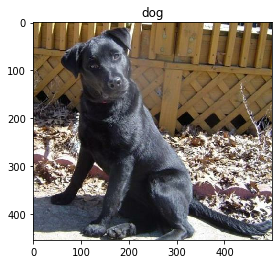

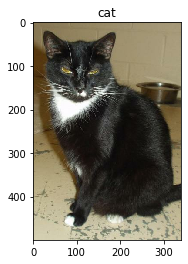

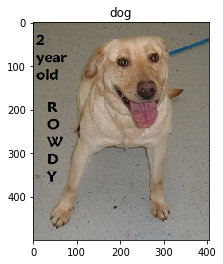

In [8]:
get_label_name = metadata.features['label'].int2str
for image, label in raw_train.take(20):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

## Format the Data

In [25]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
#     image = (image/127.5) - 1
    image = keras.applications.resnet50.preprocess_input(image)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [26]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [27]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [28]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [29]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)


base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet',)

In [30]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [31]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Add a classification head

In [32]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [33]:
prediction_layer = tf.keras.layers.Dense(1)

model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer,
])

In [34]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'],
             )

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [36]:
len(model.trainable_variables)

2

In [37]:
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 1s 53ms/step - loss: 1.1526 - accuracy: 0.3984
initial loss: 1.15
initial accuracy: 0.40


In [38]:
model.optimizer.lr = 1e-4
history = model.fit(train_batches,
                    epochs=3,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 51s 88ms/step - loss: 0.1967 - accuracy: 0.9119 - val_loss: 0.0787 - val_accuracy: 0.9729
Epoch 2/10
582/582 [==============================] - 51s 87ms/step - loss: 0.0667 - accuracy: 0.9747 - val_loss: 0.0625 - val_accuracy: 0.9746
Epoch 3/10
582/582 [==============================] - 51s 88ms/step - loss: 0.0568 - accuracy: 0.9782 - val_loss: 0.0564 - val_accuracy: 0.9733
Epoch 4/10
 15/582 [..............................] - ETA: 43s - loss: 0.0591 - accuracy: 0.9771

KeyboardInterrupt: 

In [39]:
model.optimizer.lr = 1e-3
history = model.fit(train_batches,
                    epochs=2,
                    validation_data=validation_batches)

Epoch 1/2
582/582 [==============================] - 52s 89ms/step - loss: 0.0582 - accuracy: 0.9782 - val_loss: 0.0527 - val_accuracy: 0.9798
Epoch 2/2
 17/582 [..............................] - ETA: 45s - loss: 0.0823 - accuracy: 0.9688

KeyboardInterrupt: 

In [40]:
model.optimizer.lr = 1e-6
history = model.fit(train_batches,
                    epochs=1,
                    validation_data=validation_batches)

582/582 [==============================] - 52s 89ms/step - loss: 0.0414 - accuracy: 0.9857 - val_loss: 0.0498 - val_accuracy: 0.9798


In [41]:
keras.models.save_model(model, 'model-before-unfreeze.h5')

In [43]:
base_model.trainable = True
model.optimizer.lr = 1e-6

In [44]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  175


In [45]:
warm_history = model.fit(train_batches,
                        epochs=2,
                        validation_data=validation_batches)

Epoch 1/2
582/582 [==============================] - 51s 88ms/step - loss: 0.0413 - accuracy: 0.9858 - val_loss: 0.0498 - val_accuracy: 0.9798
Epoch 2/2
582/582 [==============================] - 51s 87ms/step - loss: 0.0413 - accuracy: 0.9859 - val_loss: 0.0498 - val_accuracy: 0.9798


In [ ]:
!git st